# Acoustic Absorption calculation using the Transfer Matrix Method (TMM) and JCAL Model

This notebook explains how to use the **Transfer Matrix Method (TMM)** together with the **Johnson-Champoux-Allard-Lafarge (JCAL)** model to calculate the **acoustic absorption** of a porous material (mineral wool) covered with and without a thin plate (foil) backed by a rigid wall.
The thin plate is considered as a mass term. It's a 1D model.

---

## Table of Contents

1. [Import Libraries](#Import-Libraries)
2. [JCAL Model Functions](#Define-JCAL-Model-Functions)
4. [Material Properties](#Properties)
5. [TMM Implementation](#TMM)
6. [Results & Plots](#Plots)

---

## 1. Import Libraries


In [317]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

---

## 2. Define JCAL Model Functions

These functions define the **effective dynamic density** and **effective bulk modulus** of the porous medium according to the **JCAL model**. It uses $e^{-i\omega t}$ convention. The equations have been obtained from [https://doi.org/10.1121/1.415222]


In [318]:
# Dymanic density
def rho_eff(omega, rho0, phi, alpha_inf, sigma, eta, Lambda):
    term = 1 - (4j*alpha_inf**2 * eta * rho0 * omega) / (sigma*Lambda*phi)**2
    
    return alpha_inf * (rho0 - sigma*phi/(1j*omega*alpha_inf) * np.sqrt(term))

# Dynamic Bulk modulus 

def K_eff(gamma, P0, phi, eta, Cp, rho0, omega, kappa, Lambda_prime, NPr):
    term = 1 - 8*eta/(1j*Lambda_prime**2*NPr*omega*rho0) * np.sqrt(1 - 1j*rho0*omega*NPr*Lambda_prime/16/eta)
    return  gamma * P0 / (gamma - (gamma - 1) / term)

## 3. Material properties

The air properties, wool JCAL parameters, and surface mass density of the plate are


In [319]:
# Air properties
rho1  = 1.2             # Density [Kg/m**3]
gamma = 1.4             # Heat capacity ratio []
Cp    = 1006            # Specific heat capacity [J/(kg*K)] 
P0    = 101325          # Pressure [Pa]
mu    = 1.8e-5          # Dynamic viscosity [Pa*s]
kappa = 25e-3           # Coefficient of thermal conduction [W/(m*K)] 
NPr   = Cp * mu / kappa # Prandtl number

# Mineral wool properties
a            = 20e-3  # Thickness [m] 
sigma        = 50000  # Airflow resistivity  [Pa*s/m2] [N*s/m4]
phi          = 0.95   # Porosity []
alpha_inf    = 1.0    # Tortuosity []
Lambda       = 60e-6  # Viscous characteristic length [m]
Lambda_prime = 100e-6 # Thermal characteristic length [m]
# Note that k0_prime, the Static thermal permeability [m2] is not used in this model

# Plate properties
rhoP = 2800  * 20e-6 # Surface density [Kg/m**2]

# List of frequencies to be computed
N       = 200  # Number of points
MaxFreq = 6000 # Max frequency
MinFreq = 100  # Min frequency

FreqList = np.linspace(MinFreq,MaxFreq,N)
omegaList = FreqList * 2*np.pi

###   Remove the # symbol in the following two lines to compute the values in the One-third octave band center frequencies. ####

#omegaList = np.pi*np.array([100, 125, 160, 200, 250, 315, 400, 500, 630, 800, 1000, 
#                    1250, 1600, 2000, 2500, 3150, 4000, 5000, 6300, 8000, 10000])

N = len(omegaList)


## 4. Allocate memory for the results


In [320]:
alphaList = np.zeros([2,N])
ZList = np.zeros([2,N], dtype=complex)
B1List = np.zeros([2,N], dtype=complex)

## 5. Loop through all the frequencies, with and without considering the foil



In [321]:
for g in (0,1):
       
    for i, omega in enumerate(omegaList):
        
        # Air properties
        K1    = gamma * P0 
        k1    = omega * np.sqrt(rho1/K1) # Wave number in air
        c1    = omega/k1

        # Mineral wool properties
        rho2 = rho_eff(omega, rho1, phi, alpha_inf, sigma, mu, Lambda)
        K2   = K_eff(gamma, P0, phi, mu, Cp, rho1, omega, kappa, Lambda_prime, NPr)
        k2    = omega * np.sqrt(rho2/K2) # Wave number in wool
        c2 = omega/k2
        
        # Plate properties
        rhoP2 = rhoP*g 

        A =  np.array([[1, 0, 0, 0],
                       [1j*k1/omega**2/rho1, -1j*k1/omega**2/rho1, -1j*k2/omega**2/rho2, 1j*k2/omega**2/rho2],
                       [1 + (rhoP2*omega**2)*(1j*k1)/(omega**2*rho1), 1 - (rhoP2*omega**2)*(1j*k1)/(omega**2*rho1), -1 , -1],
                       [0, 0, 1*(1j*k2/omega**2/rho2) * np.exp(1j*k2*a), (-1j*k2/omega**2/rho2) * np.exp(-1j*k2*a)]
                       ]) 
                
        c = np.array([1,0,0,0]) 

        # Solve A@b = c
        b = np.linalg.solve(A, c)
        if(abs(A@b - c) > 1e-10).any():
            print("Error, the matrix is not good conditioned", np.linalg.cond(A))   
            
        # Reflection coefficient
        B1List[g,i] = b[1]/b[0]

        # Absorption coefficient
        alphaList[g,i] = 1 - (np.abs(b[1])) ** 2

        # Surface impedance
        ZList[g,i] = (b[0] + b[1]) / (b[0] - b[1]) * rho1 * c1  
        

## 6. Results and plotting

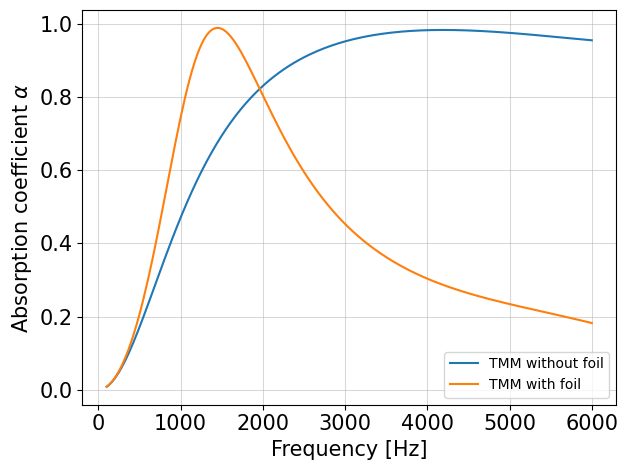

In [322]:
plt.plot(FreqList, alphaList[0], label = "TMM without foil")
plt.plot(FreqList, alphaList[1], label = "TMM with foil")

# Title and info
size = 15 # Font size
plt.xlabel("Frequency [Hz]", fontsize=size)
plt.ylabel(r"Absorption coefficient $\alpha$", fontsize=size)
plt.tick_params(axis='both', labelsize=size)
#plt.xscale("log") # This line changes the scale of the x axis
#plt.xlim(100,10e3)

#plt.title("Absorption coefficient obtained using TMM", fontsize=size) # Plot title

# Grid 
plt.grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.5)
plt.grid(True, which='minor', linestyle=':', linewidth=0.75 , alpha=0.5)
plt.legend(fontsize=size)

plt.legend()
plt.tight_layout()
plt.show()


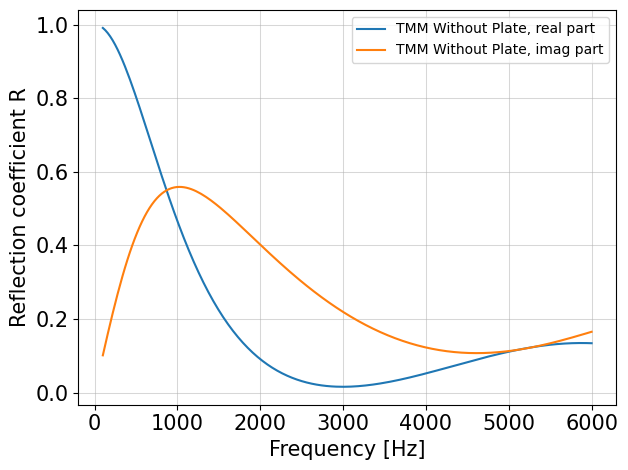

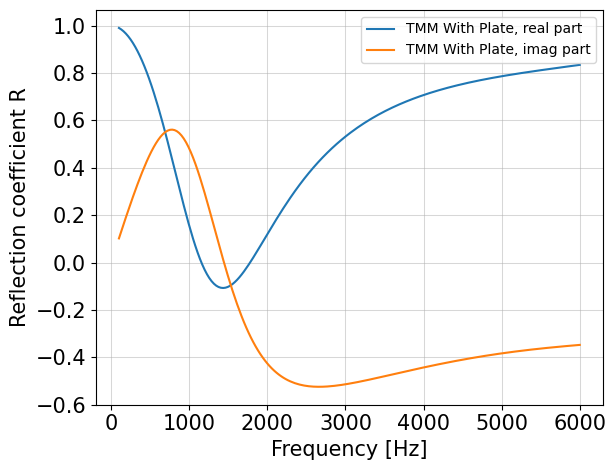

In [323]:
#### Without plate

plt.plot(FreqList, B1List[0].real, label = "TMM Without Plate, real part")
plt.plot(FreqList, B1List[0].imag, label = "TMM Without Plate, imag part")
# Title and info
size = 15 # Font size
plt.xlabel("Frequency [Hz]", fontsize=size)
plt.ylabel(r"Reflection coefficient R", fontsize=size)
plt.tick_params(axis='both', labelsize=size)
#plt.xscale("log") # This line changes the scale of the x axis
#plt.xlim(100,10e3)

#plt.title("Reflection coefficient obtained using TMM", fontsize=size) # Plot title

# Grid 
plt.grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.5)
plt.grid(True, which='minor', linestyle=':', linewidth=0.75 , alpha=0.5)
plt.legend(fontsize=size)

plt.legend()
plt.tight_layout()
plt.show()

#### With plate

plt.plot(FreqList, B1List[1].real, label = "TMM With Plate, real part")
plt.plot(FreqList, B1List[1].imag, label = "TMM With Plate, imag part")
# Title and info
size = 15 # Font size
plt.xlabel("Frequency [Hz]", fontsize=size)
plt.ylabel(r"Reflection coefficient R", fontsize=size)
plt.tick_params(axis='both', labelsize=size)
#plt.xscale("log") # This line changes the scale of the x axis
#plt.xlim(100,10e3)

#plt.title("Reflection coefficient obtained using TMM", fontsize=size) # Plot title

# Grid 
plt.grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.5)
plt.grid(True, which='minor', linestyle=':', linewidth=0.75 , alpha=0.5)
plt.legend(fontsize=size)

plt.legend()
plt.tight_layout()
plt.show()


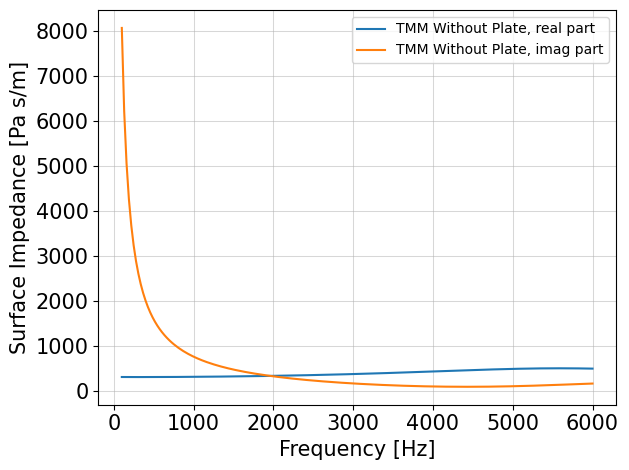

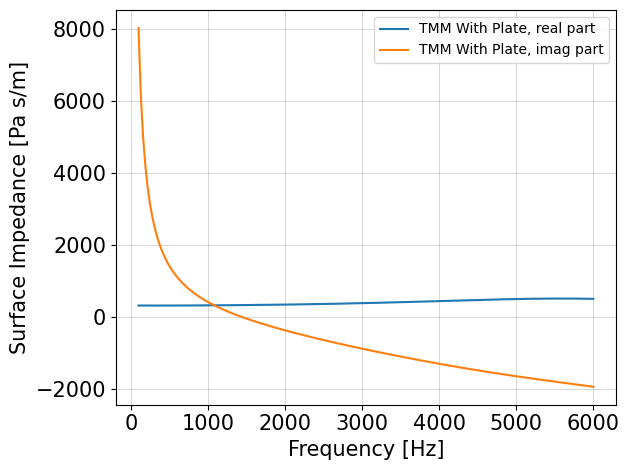

In [324]:
#### Without plate

plt.plot(FreqList, ZList[0].real, label = "TMM Without Plate, real part")
plt.plot(FreqList, ZList[0].imag, label = "TMM Without Plate, imag part")
# Title and info
size = 15 # Font size
plt.xlabel("Frequency [Hz]", fontsize=size)
plt.ylabel("Surface Impedance [Pa s/m]", fontsize=size)
plt.tick_params(axis='both', labelsize=size)
#plt.xscale("log") # This line changes the scale of the x axis
#plt.xlim(100,10e3)

#plt.title("Surface Impedance obtained using TMM", fontsize=size) # Plot title

# Grid 
plt.grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.5)
plt.grid(True, which='minor', linestyle=':', linewidth=0.75 , alpha=0.5)
plt.legend(fontsize=size)

plt.legend()
plt.tight_layout()
plt.show()

#### With plate

plt.plot(FreqList, ZList[1].real, label = "TMM With Plate, real part")
plt.plot(FreqList, ZList[1].imag, label = "TMM With Plate, imag part")
# Title and info
size = 15 # Font size
plt.xlabel("Frequency [Hz]", fontsize=size)
plt.ylabel("Surface Impedance [Pa s/m]", fontsize=size)
plt.tick_params(axis='both', labelsize=size)
#plt.xscale("log") # This line changes the scale of the x axis
#plt.xlim(100,10e3)

#plt.title("Surface Impedance obtained using TMM", fontsize=size) # Plot title

# Grid 
plt.grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.5)
plt.grid(True, which='minor', linestyle=':', linewidth=0.75 , alpha=0.5)
plt.legend(fontsize=size)

plt.legend()
plt.tight_layout()
plt.show()

## 7. Saving the data in a CSV

In [325]:
df = pd.DataFrame({
    'Frequency': FreqList, 
    'Absorption without plate': alphaList[0],
    'Absorption with plate': alphaList[1],
    'Reflection without plate': B1List[0], 
    'Reflection with plate': B1List[1],  
    'Surface impedance without plate': ZList[0],  
    'Surface impedance with plate': ZList[1]
})
#print(df.head)
df.to_csv('TMM JCAL.csv', index=False)